# Prioritized sweeping

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../../modules')

import json

import random
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from env.gridworld import VanillaGridWorld
from policy import EpsilonGreedyPolicy

from algo.planning import QLearningBase

from algo.planning_cbs.cb_handler import CallbackHandler
from algo.planning_cbs.dynaq import DynaQ
from algo.planning_cbs.prioritized_sweeping import PrioritizedSweeping
from algo.planning_cbs.episode_length_tracker import EpisodeLengthTracker

In [3]:
npy_save_dir = 'files'
img_save_dir = '/Users/yangzhihan/Desktop/projects/deeprl_notes_site/images/2020-08-20-prioritized-sweeping'

## Run the algorithm

In [29]:
planning_ratio = 3

In [30]:
env = VanillaGridWorld(num_rows=10, num_cols=10, start_coord=(0, 0), end_coord=(9, 9), mode=1)

In [25]:
np.random.seed(30)
random.seed(30)

algo1 = QLearningBase(
    env=env, 
    policy=EpsilonGreedyPolicy(q=np.zeros(env.action_space_shape), epsilon=0.1), 
    alpha=1, 
    gamma=0.95, 
    cb_handler=CallbackHandler(
        cbs=[
            DynaQ(planning_ratio),
            EpisodeLengthTracker(),
        ]
    )
)

algo1.run(max_iterations=100, which_tqdm='notebook')

#np.save(f'{npy_save_dir}/prioritized_sweeping_{planning_ratio}_online_trajectory_lengths.npy', np.array(el_tracker.values))

In [93]:
np.random.seed(30)
random.seed(30)

algo2 = QLearningBase(
    env=env, 
    policy=EpsilonGreedyPolicy(q=np.zeros(env.action_space_shape), epsilon=0.1), 
    alpha=1, 
    gamma=0.95, 
    cb_handler=CallbackHandler(
        cbs=[
            PrioritizedSweeping(planning_ratio, td_error_threshold=1e-2),
            EpisodeLengthTracker(),
        ]
    )
)

algo2.run(max_iterations=100, which_tqdm='notebook')

#np.save(f'{npy_save_dir}/prioritized_sweeping_{planning_ratio}_online_trajectory_lengths.npy', np.array(el_tracker.values))

In [74]:
np.min(algo1.cb_handler.cbs[1].values), np.min(algo2.cb_handler.cbs[1].values)

(18, 18)

In [75]:
num_values = len(algo1.cb_handler.cbs[1].values)

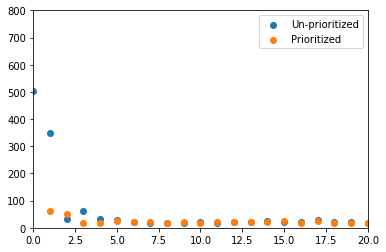

In [76]:
plt.scatter(np.arange(num_values), algo1.cb_handler.cbs[1].values, label='Un-prioritized')
plt.scatter(np.arange(num_values), algo2.cb_handler.cbs[1].values, label='Prioritized')
plt.legend()
plt.ylim(0, 800)
plt.xlim(0, 20)
plt.show()

In [94]:
len(algo2.cb_handler.cbs[0].qs)

1558

In [95]:
np.max(algo2.cb_handler.cbs[0].priorities)

1.0

In [79]:
with open('prioritized_sweeping_first_two_episodes_qs.json', 'w+') as json_f:
    json.dump([arr.tolist() for arr in algo2.cb_handler.cbs[0].qs], json_f)

In [80]:
with open('states.json', 'w+') as json_f:
    json.dump(np.array(algo2.cb_handler.cbs[0].states).tolist(), json_f)

In [81]:
with open('actions.json', 'w+') as json_f:
    json.dump(np.array(algo2.cb_handler.cbs[0].actions).tolist(), json_f)

In [82]:
with open('next_states.json', 'w+') as json_f:
    json.dump(np.array(algo2.cb_handler.cbs[0].next_states).tolist(), json_f)

In [83]:
with open('argmax_next_actions.json', 'w+') as json_f:
    json.dump(np.array(algo2.cb_handler.cbs[0].argmax_next_actions).tolist(), json_f)

In [84]:
with open('q_statuses.json', 'w+') as json_f:
    json.dump(np.array(algo2.cb_handler.cbs[0].q_statuses).tolist(), json_f)

In [96]:
with open('priorities.json', 'w+') as json_f:
    json.dump(np.array(algo2.cb_handler.cbs[0].priorities).tolist(), json_f)

## Visualize online performance

In [33]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    \
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

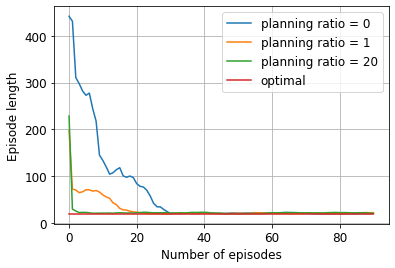

In [39]:
plt.rcParams.update({'font.size': 12})

window_size = 10

plt.plot(smooth(num_planning_steps_0, window_size), label='planning ratio = 0')
plt.plot(smooth(num_planning_steps_1, window_size), label='planning ratio = 1')
plt.plot(smooth(num_planning_steps_20, window_size), label='planning ratio = 20')
plt.plot([0, len(num_planning_steps_0)-window_size], [19, 19], label='optimal')

plt.grid()

plt.xlabel('Number of episodes'); plt.ylabel('Episode length')
plt.legend()

plt.savefig(f'{img_save_dir}/dynaq_online_performance.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

## Effect of no planning vs. planning

In [152]:
# after the first action has been taken in the second episode + planning for one state-action pair
q = algo2.cb_handler.cbs[2].after_first_episode_q
learned_policy = q.argmax(axis=-1)

In [153]:
ix_to_str = {
    0 : r'$\uparrow$',
    1 : r'$\rightarrow$',
    2 : r'$\downarrow$',
    3 : r'$\leftarrow$'
}

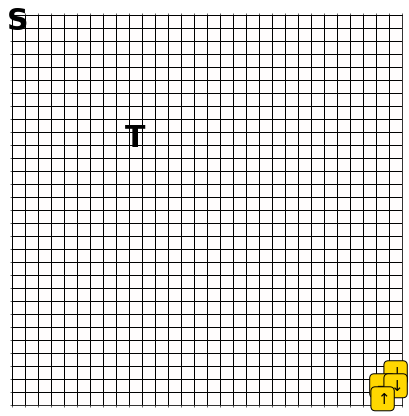

In [156]:
plt.figure(figsize=(15, 7))

plt.matshow(np.zeros_like(learned_policy), fignum=1, vmin=-1, vmax=1, cmap='seismic')

for (i, j), z in np.ndenumerate(learned_policy):
    
    if not np.all(q[i, j][0] == q[i, j]):

        # sanity check: start
        
        env.current_coord = (i, j)
        while True:
            env.step(learned_policy[env.current_coord])
            if env.is_episode_terminated():
                break
                
        # sanity check: end
            
        plt.text(
            j, i, ix_to_str[int(z)], 
            ha='center', va='center', color='black', fontsize=15, weight='bold',
            bbox=dict(boxstyle='round', facecolor='gold', edgecolor='0')
        )
        
    if (i, j) == (0, 0):
        
        plt.text(
            j, i, 'S',
            ha='center', va='center', color='black', fontsize=30, weight='bold',
        )
        
    elif (i, j) == (9, 9):
        
        plt.text(
            j, i, 'T',
            ha='center', va='center', color='black', fontsize=30, weight='bold',
        )

plt.xticks([]); plt.yticks([])

ax = plt.gca()
ax.set_xticks(np.arange(-.5, 30, 1), minor=True);
ax.set_yticks(np.arange(-.5, 30, 1), minor=True);
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
#plt.savefig(f'{img_save_dir}/dynaq_n20_after_first_episode_policy.png', dpi=300, bbox_inches = 'tight', pad_inches = 0.1)

In [185]:
# halfway through the second episode; in Q-learning, the second episode propagate values one state-action pair backward
q = algo2.cb_handler.cbs[2].after_second_episode_q
learned_policy = q.argmax(axis=-1)

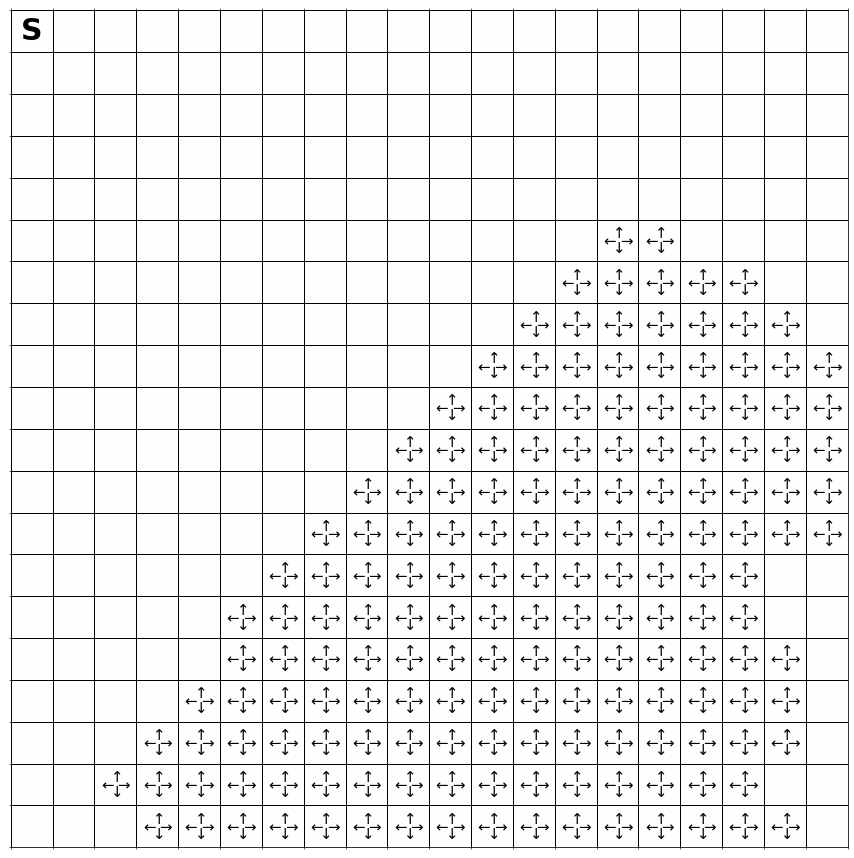

In [198]:
plt.figure(figsize=(15, 15))

plt.matshow(np.zeros_like(learned_policy), fignum=1, vmin=-1, vmax=1, cmap='seismic')

for (i, j), z in np.ndenumerate(learned_policy):
    
    if not np.all(q[i, j][0] == q[i, j]):

        # sanity check: start
        
        env.current_coord = (i, j)
        while True:
            env.step(learned_policy[env.current_coord])
            if env.is_episode_terminated():
                break
                
        # sanity check: end
            
#         plt.text(
#             j, i, ix_to_str[int(z)], 
#             ha='left', va='center', color='black', fontsize=15, weight='bold',
#         )
        
        plt.text(
            j, i, ix_to_str[0], 
            ha='center', va='bottom', color='black', fontsize=15, weight='bold',
        )
        
        plt.text(
            j, i, ix_to_str[2], 
            ha='center', va='top', color='black', fontsize=15, weight='bold',
        )
        
        plt.text(
            j, i, ix_to_str[1], 
            ha='left', va='center', color='black', fontsize=15, weight='bold',
        )
        
        plt.text(
            j, i, ix_to_str[3], 
            ha='right', va='center', color='black', fontsize=15, weight='bold',
        )
        
    if (i, j) == (0, 0):
        
        plt.text(
            j, i, 'S',
            ha='center', va='center', color='black', fontsize=30, weight='bold',
        )
        
    elif (i, j) == (29, 29):
        
        plt.text(
            j, i, 'T',
            ha='center', va='center', color='black', fontsize=30, weight='bold',
        )

plt.xticks([]); plt.yticks([])

ax = plt.gca()
ax.set_xticks(np.arange(-.5, 20, 1), minor=True);
ax.set_yticks(np.arange(-.5, 20, 1), minor=True);
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
#plt.savefig(f'{img_save_dir}/dynaq_n20_after_second_episode_policy.png', dpi=300, bbox_inches = 'tight', pad_inches = 0.1)

## Efficiency of policy learning

In [45]:
learned_policies = []
for q in q_tracker.during_second_episode_qs:
    learned_policies.append(q.argmax(axis=-1))

In [46]:
len(q_tracker.during_second_episode_qs)

59

In [47]:
num_qs_updated_total = 0
num_qs_updated_total_s = []
num_actions_updated_total = 0
num_actions_updated_total_s = []
for i, (q, p) in enumerate(zip(q_tracker.during_second_episode_qs, learned_policies)):
    if i != 0:
        
        num_qs_updated = np.sum(q != q_tracker.during_second_episode_qs[i-1])
        num_qs_updated_total += num_qs_updated
        num_qs_updated_total_s.append(num_qs_updated_total)
        
        num_actions_updated = np.sum(p != learned_policies[i-1])
        num_actions_updated_total += num_actions_updated
        num_actions_updated_total_s.append(num_actions_updated_total)

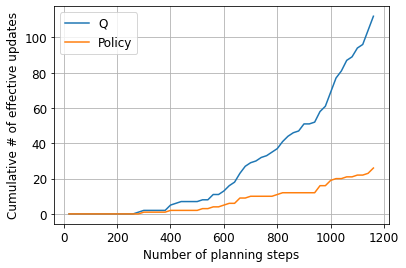

In [49]:
plt.plot(np.arange(1, len(num_qs_updated_total_s)+1)*20, num_qs_updated_total_s, label='Q')
plt.plot(np.arange(1, len(num_qs_updated_total_s)+1)*20, num_actions_updated_total_s, label='Policy')

plt.xlabel('Number of planning steps')
plt.ylabel('Cumulative # of effective updates')
plt.legend()

plt.grid()
plt.savefig(f'{img_save_dir}/dynaq_n20_efficiency.png', dpi=300, bbox_inches = 'tight', pad_inches = 0)